This analysis examines the relationship between target position and LFADS inferred input pulses. The value of the inferred input pulses are defined as the integral of the inputs in a 200ms window centered on the peak of the input pulse that follows target appearance. The window used here start at 50ms after target appearance to 300ms after target appearance. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../src')
sys.path.insert(0, 'src') #for running notebook from project root
from process_inputs import get_input_peaks
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns


In [2]:
data_filename = snakemake.input[0]
lfads_filename = snakemake.input[1]
inputInfo_filename = snakemake.input[2]

df = get_input_peaks(data_filename, lfads_filename, inputInfo_filename)
df['input_1'] = df['integral_input_1']
df['input_2'] = df['integral_input_2']

The following plots the relationship between the distance between the target and the hand at target appearance, and the summed absolute value of the inputs: 

r = 0.010509


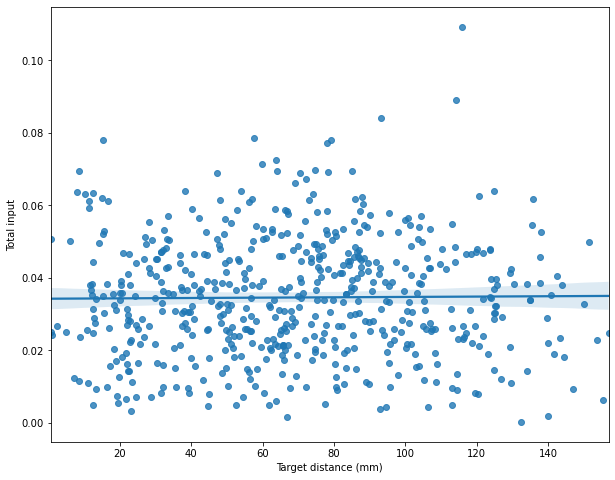

In [3]:
sns.regplot(df['target_dist'], np.abs(df['input_1'].values) + np.abs(df['input_2'].values))
plt.xlabel('Target distance (mm)')
plt.ylabel('Total input')

r = np.corrcoef(df['target_dist'], np.abs(df['input_1'].values) + np.abs(df['input_2'].values))[1,0]
print("r = %f"%r)

The following plots the relationship between the angle defining the direction from the hand to the target, and the summed absolute value of the inputs.

Text(0, 0.5, 'Total input')

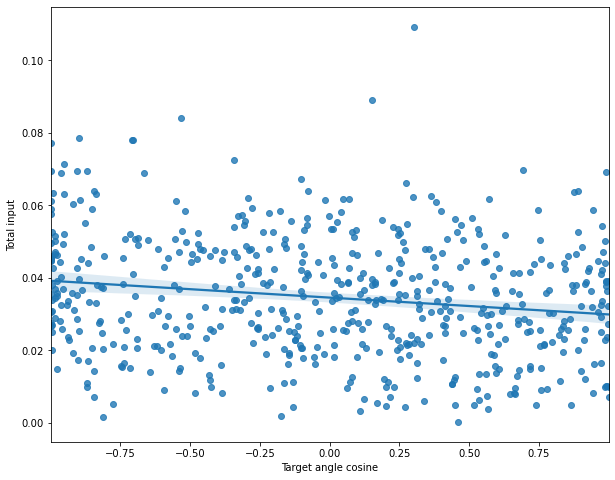

In [4]:
df['target_dir_x'] = df['target_x'] - df['x'] 
df['target_dir_y'] = df['target_y'] - df['y']
df['target_angle_cos'] = np.cos(np.arctan2(df['target_dir_x'], df['target_dir_y']))
sns.regplot(df['target_angle_cos'], np.abs(df['input_1'].values) + np.abs(df['input_2']))
plt.xlabel("Target angle cosine")
plt.ylabel('Total input')


Now we'll calculate angle between the hand velocity at target appearance and the vector that points to the target. We will plot that angle against the summed input.

Text(0, 0.5, 'Summed input')

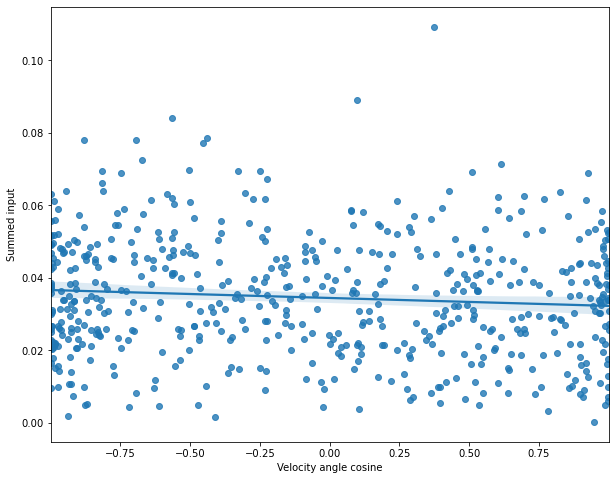

In [5]:
df['vel_angle_cos'] = np.cos(np.arctan2(df['target_x'] - df['x_vel'], df['target_y'] - df['y_vel']))
sns.regplot(df['vel_angle_cos'], np.abs(df['input_1'].values) + np.abs(df['input_2'].values))
plt.xlabel('Velocity angle cosine')
plt.ylabel("Summed input")

Now we'll look at the values obtained by both input peaks and see if there's a linear relationship to the target position. To do so, we'll plot the least squares fit of the target position using both inputs:

r = 0.306606


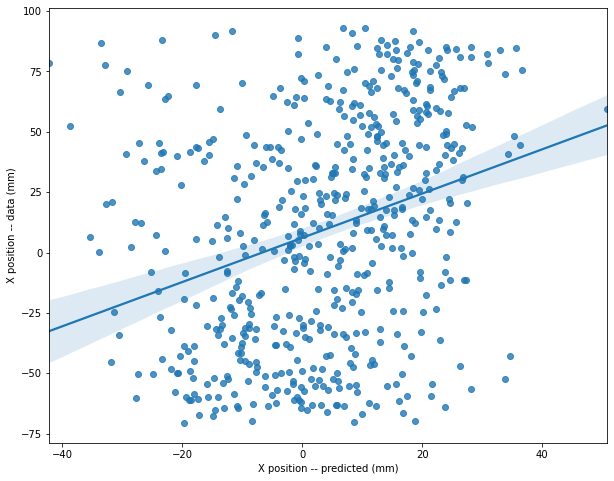

In [6]:
a = df[['input_1','input_2']].values
b = df[['target_x','target_y']].values

x,_,_,_=np.linalg.lstsq(a,b)

sns.regplot(a.dot(x)[:,0], b[:,0])
plt.xlabel("X position -- predicted (mm)")
plt.ylabel("X position -- data (mm)")

r = np.corrcoef(a.dot(x)[:,0], b[:,0])[1,0]
print("r = %f"%r)

r = 0.469738


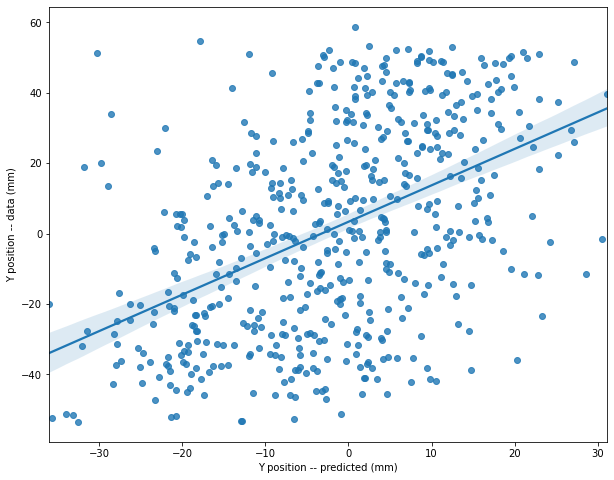

In [7]:
sns.regplot(a.dot(x)[:,1], b[:,1])
plt.xlabel("Y position -- predicted (mm)")
plt.ylabel("Y position -- data (mm)")

r = np.corrcoef(a.dot(x)[:,1], b[:,1])[1,0]
print("r = %f"%r)

Now we'll do the same thing but using position relative to the hand:



r = 0.345261


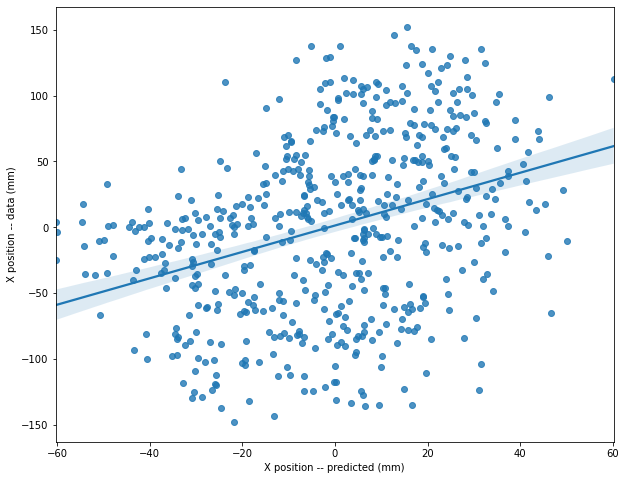

In [8]:
a = df[['input_1','input_2']].values
b = df[['target_dir_x','target_dir_y']].values

x,_,_,_=np.linalg.lstsq(a,b)

sns.regplot(a.dot(x)[:,0], b[:,0])
plt.xlabel("X position -- predicted (mm)")
plt.ylabel("X position -- data (mm)")

r = np.corrcoef(a.dot(x)[:,0], b[:,0])[1,0]
print("r = %f"%r)

r = 0.479287


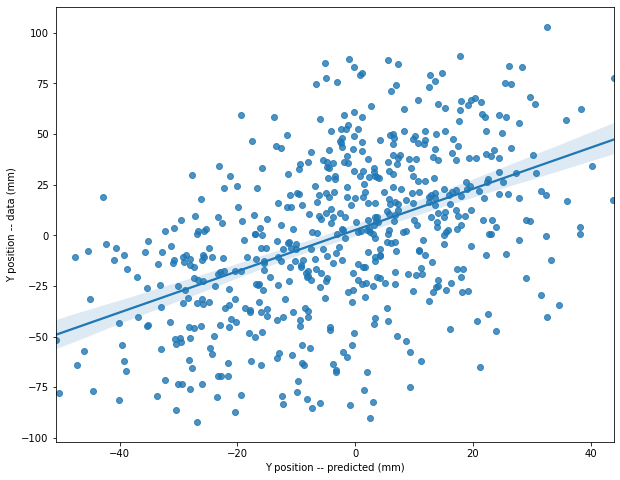

In [9]:
sns.regplot(a.dot(x)[:,1], b[:,1])
plt.xlabel("Y position -- predicted (mm)")
plt.ylabel("Y position -- data (mm)")

r = np.corrcoef(a.dot(x)[:,1], b[:,1])[1,0]
print("r = %f"%r)

First we'll look at the distribution of input values. The most common pattern by far is a negative peak in input 1 and a positive peak in input 2.

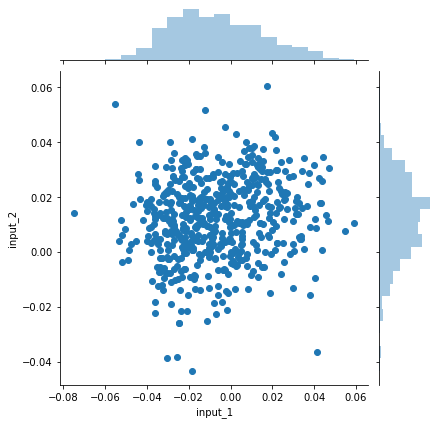

In [10]:
sns.jointplot(df['input_1'], df['input_2'])

We will look at how these four clusters map on to kinematic variables, although the distinctness clusters result from taking the maximum absolute value and doesn't necessarily represent a clustering of input patterns. Although the most common pattern is a negative input 1 and a positive input 2. The clusters in the 1st and 3rd quardrants (blue and green bars below), however, are somewhat associated with distinct kinematics. The 1st quadrant is associated with movements inward and to the left, and the 3rd quadrant is associated with movements outward. 

First, we will plot the x and y position of the target accross the four clusters:

p = 0.000000
p = 0.000000


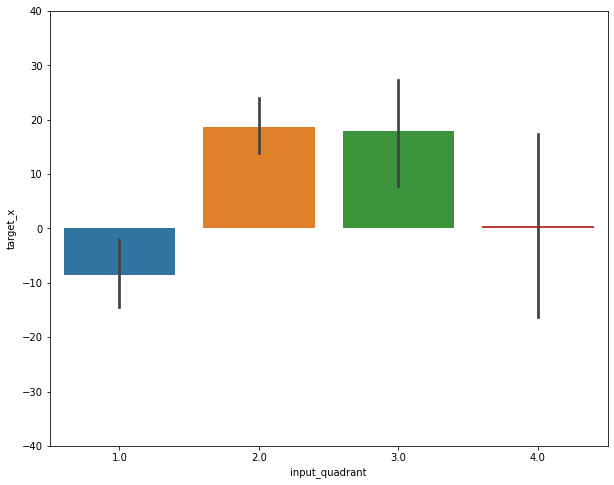

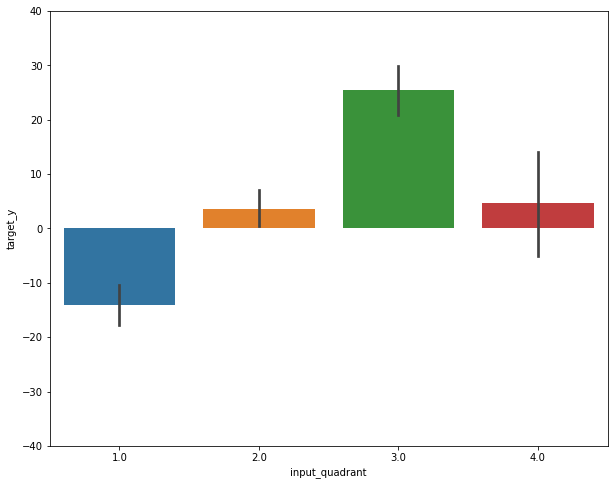

In [11]:
from scipy.stats import kruskal

df.loc[df.eval('input_1 > 0 and input_2 > 0'),'input_quadrant'] = 1
df.loc[df.eval('input_1 < 0 and input_2 > 0'),'input_quadrant'] = 2
df.loc[df.eval('input_1 < 0 and input_2 < 0'),'input_quadrant'] = 3
df.loc[df.eval('input_1 > 0 and input_2 < 0'),'input_quadrant'] = 4

sns.barplot(x='input_quadrant', y='target_x', data=df)
plt.ylim([-40, 40])
p = kruskal(*[_df['target_x'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)
plt.figure()
sns.barplot(x='input_quadrant', y='target_y', data=df)
plt.ylim([-40, 40])
p = kruskal(*[_df['target_y'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)


Next, the x and y target position relative to the hand:

p = 0.000000
p = 0.000000


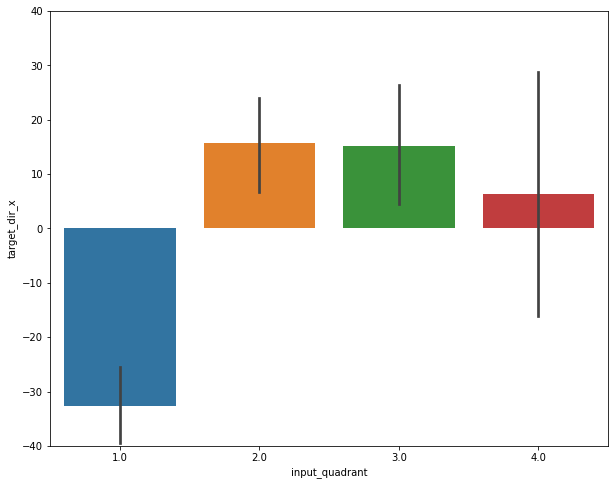

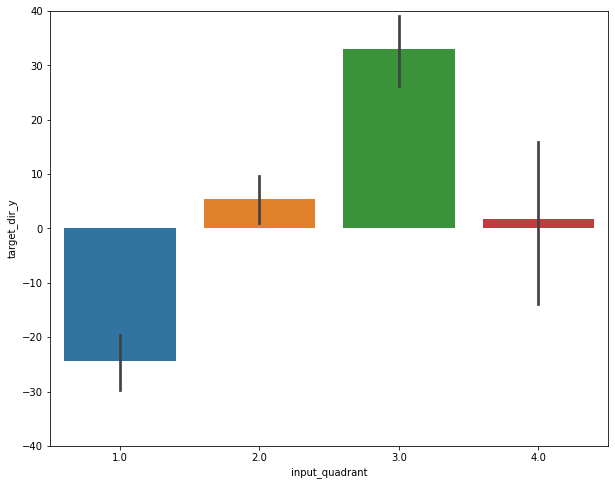

In [12]:
sns.barplot(x='input_quadrant', y='target_dir_x', data=df)
plt.ylim([-40, 40])
p = kruskal(*[_df['target_dir_x'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)
plt.figure()
sns.barplot(x='input_quadrant', y='target_dir_y', data=df)
plt.ylim([-40, 40])
p = kruskal(*[_df['target_dir_y'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)

And the angle relative to the hand:

p = 0.000000


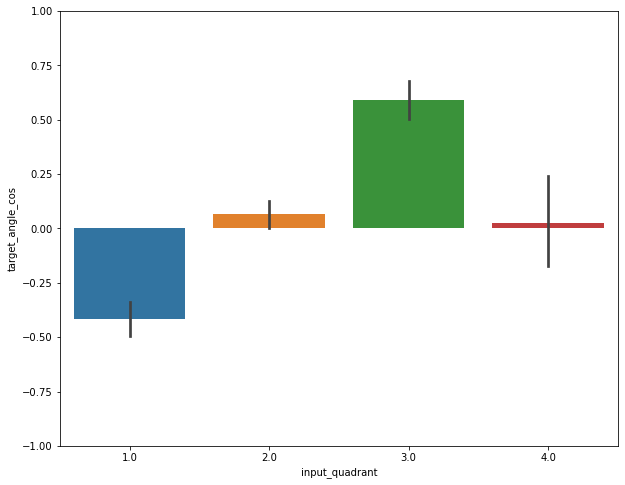

In [13]:
plt.figure()
sns.barplot(x='input_quadrant', y='target_angle_cos', data=df)
plt.ylim([-1, 1])
p = kruskal(*[_df['target_angle_cos'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)

Finally, the difference in angle between hand velocity and target position:

p = 0.000000


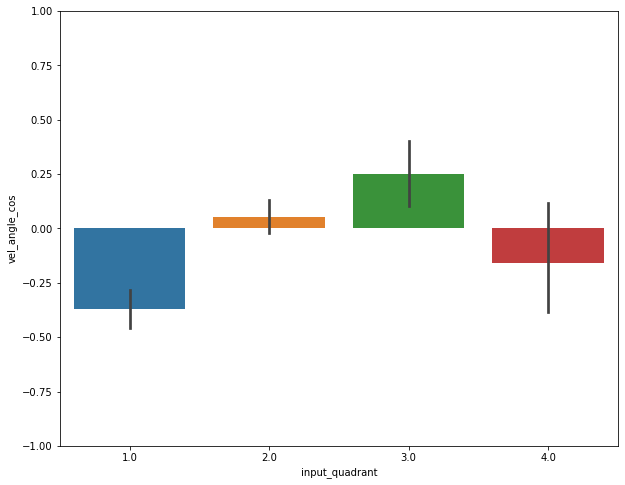

In [14]:
sns.barplot(x='input_quadrant', y='vel_angle_cos', data=df)
plt.ylim([-1, 1])
p = kruskal(*[_df['vel_angle_cos'].values for _,_df in df.groupby("input_quadrant")])[1]
print("p = %f"%p)